<h1>Bank Churn Prediction</h1>

<span style="color:blue">Objective:</span></p>
Given a Bank customer, build a neural network based classifier that can determine whether they will leave
or not in the next 6 months.
<p></p>
<span style="color:blue">Context:</span><br></br>
Businesses like banks which provide service have to worry about problem of 'Churn' i.e. customers
leaving and joining another service provider. It is important to understand which aspects of the service
influence a customer's decision in this regard. Management can concentrate efforts on improvement of
service, keeping in mind these priorities

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('bank.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()
### This dataset contains int64 values so i will need to change to float64 later because 
### this version of tensorflow requires it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


<h4>I will remove the unique fields in the dataset, or those that appears to be an id because they are not adding any value to the model, the output of our model is the Exited column, because we need to predict if the costumer is exited according to the input values that we will provide</h4>

In [5]:
df = df.iloc[:,2:]

In [6]:
## We can drop RowNumber and CustomerId because they are just unique
df.nunique()

Surname            2932
CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [7]:
### Cast this column as the output value, it has to be float64
df['Exited'] = df['Exited'].astype('float64')

In [8]:
### It seems that we can convert the gender into an integer 0=Male, 1=Female
df["Gender"] = df["Gender"].map({"Female": 1, "Male": 0})

In [9]:
### For the Geography i will need them in a numerical value but i won't add more columns to avoid more 
### compute procesing
df["Geography"] = df["Geography"].astype('category').cat.codes

In [10]:
### The interest of this exercise is to find if a customer is going to cancell the services or not, 
### so the target variable will be the column Exited
Y = df.iloc[:,-1:].values

In [11]:
### The rest of the columns will be used as input variables
X = df.iloc[:,1:-1].values

In [12]:
X.shape

(10000, 10)

In [13]:
#### Spliting the dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 30)

Feature scaling is a method used to standardize the range of independent variables or features of data. It is basically scaling all the dimensions to be even so that one independent variable does not dominate another. For example, bank account balance ranges from millions to 0, whereas gender is either 0 or 1. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

For this example i wil use normal zscale transformation.

In [14]:
### normalizing X data
zscale = StandardScaler()
X_train = zscale.fit_transform(X_train)
X_test = zscale.fit_transform(X_test)

<h3>During the model creation process, i did try several approaches:</h3>

<br><b>1) Intent 1</b>: 2 hidden layers, First layer with 10 neurons second layer with 5 neurons and using relu as activation function. The result was not good enough, having 80% of accurancy and a lot of errors</br>
<br><b>2) Intent 2</b>: 3 hidden layers, First layer with 13 neurons, second layer with 8 neurons and third layer with 3 neurons, activation function remains relu and the number of epocs was changed to 100. The process was really slow and the accurancy was something no more than 86% which still is not good enough.</br>
<br><b>3) Intent 3</b>: Same configuration as the second approach but this time i changed the activation function. I used a combination of selu and tanh for the layers. Same result and even more slower than the second approach.</br>
<br><b>4) Intent 4</b>: This was the best configuration that i found, using 3 hidden layers, with 30 neurons each and using relu as an activation function the accurancy goes from 82% to 94%. Also i found that using more epocs we can improve this accuracy.</br>

In [15]:
tf.keras.backend.set_floatx('float64')
model = Sequential()
## First hidden layer
model.add(Dense(30, activation='relu', kernel_initializer='normal'))
## Second hidden layer
model.add(Dense(30, activation='relu', kernel_initializer='normal'))
## Third hidden layer
model.add(Dense(30, activation='relu', kernel_initializer='normal'))
### The outpunt layer
model.add(Dense(1))

In [16]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer , metrics = ['accuracy','mae' , 'mse'])

In [17]:
hist = model.fit(X_train, y_train, epochs=400, validation_split = 0.1, verbose=1)

Epoch 1/400
225/225 [==============================] - 1s 4ms/step - loss: 0.1369 - accuracy: 0.8164 - mae: 0.2705 - mse: 0.1369 - val_loss: 0.1179 - val_accuracy: 0.8425 - val_mae: 0.2398 - val_mse: 0.1179
Epoch 2/400
225/225 [==============================] - 1s 2ms/step - loss: 0.1133 - accuracy: 0.8485 - mae: 0.2317 - mse: 0.1133 - val_loss: 0.1107 - val_accuracy: 0.8488 - val_mae: 0.2309 - val_mse: 0.1107
Epoch 3/400
225/225 [==============================] - 0s 2ms/step - loss: 0.1096 - accuracy: 0.8575 - mae: 0.2225 - mse: 0.1096 - val_loss: 0.1101 - val_accuracy: 0.8575 - val_mae: 0.2189 - val_mse: 0.1101
Epoch 4/400
225/225 [==============================] - 0s 2ms/step - loss: 0.1067 - accuracy: 0.8599 - mae: 0.2184 - mse: 0.1067 - val_loss: 0.1088 - val_accuracy: 0.8562 - val_mae: 0.2198 - val_mse: 0.1088
Epoch 5/400
225/225 [==============================] - 0s 2ms/step - loss: 0.1057 - accuracy: 0.8590 - mae: 0.2161 - mse: 0.1057 - val_loss: 0.1138 - val_accuracy: 0.8450 -

225/225 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.8826 - mae: 0.1847 - mse: 0.0900 - val_loss: 0.1220 - val_accuracy: 0.8387 - val_mae: 0.2167 - val_mse: 0.1220
Epoch 41/400
225/225 [==============================] - 0s 1ms/step - loss: 0.0893 - accuracy: 0.8815 - mae: 0.1818 - mse: 0.0893 - val_loss: 0.1152 - val_accuracy: 0.8538 - val_mae: 0.2060 - val_mse: 0.1152
Epoch 42/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0898 - accuracy: 0.8788 - mae: 0.1832 - mse: 0.0898 - val_loss: 0.1186 - val_accuracy: 0.8475 - val_mae: 0.2079 - val_mse: 0.1186
Epoch 43/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0888 - accuracy: 0.8810 - mae: 0.1817 - mse: 0.0888 - val_loss: 0.1198 - val_accuracy: 0.8413 - val_mae: 0.2135 - val_mse: 0.1198
Epoch 44/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0886 - accuracy: 0.8803 - mae: 0.1803 - mse: 0.0886 - val_loss: 0.1208 - val_accuracy: 0.8462 - val_mae

225/225 [==============================] - 0s 2ms/step - loss: 0.0783 - accuracy: 0.8982 - mae: 0.1636 - mse: 0.0783 - val_loss: 0.1294 - val_accuracy: 0.8350 - val_mae: 0.2170 - val_mse: 0.1294
Epoch 80/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0786 - accuracy: 0.8982 - mae: 0.1641 - mse: 0.0786 - val_loss: 0.1296 - val_accuracy: 0.8363 - val_mae: 0.2155 - val_mse: 0.1296
Epoch 81/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0778 - accuracy: 0.8962 - mae: 0.1624 - mse: 0.0778 - val_loss: 0.1280 - val_accuracy: 0.8350 - val_mae: 0.2098 - val_mse: 0.1280
Epoch 82/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0773 - accuracy: 0.9011 - mae: 0.1615 - mse: 0.0773 - val_loss: 0.1297 - val_accuracy: 0.8337 - val_mae: 0.2103 - val_mse: 0.1297
Epoch 83/400
225/225 [==============================] - 1s 2ms/step - loss: 0.0775 - accuracy: 0.8974 - mae: 0.1619 - mse: 0.0775 - val_loss: 0.1293 - val_accuracy: 0.8425 - val_mae

225/225 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9106 - mae: 0.1504 - mse: 0.0693 - val_loss: 0.1377 - val_accuracy: 0.8325 - val_mae: 0.2142 - val_mse: 0.1377
Epoch 119/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9137 - mae: 0.1490 - mse: 0.0691 - val_loss: 0.1396 - val_accuracy: 0.8200 - val_mae: 0.2172 - val_mse: 0.1396
Epoch 120/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9118 - mae: 0.1488 - mse: 0.0688 - val_loss: 0.1374 - val_accuracy: 0.8275 - val_mae: 0.2140 - val_mse: 0.1374
Epoch 121/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 0.9111 - mae: 0.1499 - mse: 0.0687 - val_loss: 0.1349 - val_accuracy: 0.8313 - val_mae: 0.2147 - val_mse: 0.1349
Epoch 122/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9131 - mae: 0.1484 - mse: 0.0682 - val_loss: 0.1389 - val_accuracy: 0.8313 - val

225/225 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9218 - mae: 0.1415 - mse: 0.0631 - val_loss: 0.1438 - val_accuracy: 0.8263 - val_mae: 0.2219 - val_mse: 0.1438
Epoch 158/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 0.9222 - mae: 0.1404 - mse: 0.0625 - val_loss: 0.1408 - val_accuracy: 0.8225 - val_mae: 0.2247 - val_mse: 0.1408
Epoch 159/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0626 - accuracy: 0.9231 - mae: 0.1411 - mse: 0.0626 - val_loss: 0.1538 - val_accuracy: 0.8200 - val_mae: 0.2355 - val_mse: 0.1538
Epoch 160/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 0.9221 - mae: 0.1402 - mse: 0.0623 - val_loss: 0.1419 - val_accuracy: 0.8250 - val_mae: 0.2256 - val_mse: 0.1419
Epoch 161/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0620 - accuracy: 0.9239 - mae: 0.1397 - mse: 0.0620 - val_loss: 0.1403 - val_accuracy: 0.8163 - val

225/225 [==============================] - 0s 2ms/step - loss: 0.0577 - accuracy: 0.9294 - mae: 0.1334 - mse: 0.0577 - val_loss: 0.1407 - val_accuracy: 0.8325 - val_mae: 0.2155 - val_mse: 0.1407
Epoch 197/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0578 - accuracy: 0.9294 - mae: 0.1342 - mse: 0.0578 - val_loss: 0.1542 - val_accuracy: 0.8213 - val_mae: 0.2289 - val_mse: 0.1542
Epoch 198/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0569 - accuracy: 0.9301 - mae: 0.1323 - mse: 0.0569 - val_loss: 0.1541 - val_accuracy: 0.8137 - val_mae: 0.2247 - val_mse: 0.1541
Epoch 199/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0572 - accuracy: 0.9311 - mae: 0.1331 - mse: 0.0572 - val_loss: 0.1528 - val_accuracy: 0.8200 - val_mae: 0.2284 - val_mse: 0.1528
Epoch 200/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0569 - accuracy: 0.9313 - mae: 0.1325 - mse: 0.0569 - val_loss: 0.1519 - val_accuracy: 0.8163 - val

225/225 [==============================] - 1s 2ms/step - loss: 0.0539 - accuracy: 0.9350 - mae: 0.1285 - mse: 0.0539 - val_loss: 0.1569 - val_accuracy: 0.8187 - val_mae: 0.2264 - val_mse: 0.1569
Epoch 236/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0544 - accuracy: 0.9369 - mae: 0.1301 - mse: 0.0544 - val_loss: 0.1679 - val_accuracy: 0.8087 - val_mae: 0.2338 - val_mse: 0.1679
Epoch 237/400
225/225 [==============================] - 1s 2ms/step - loss: 0.0538 - accuracy: 0.9364 - mae: 0.1287 - mse: 0.0538 - val_loss: 0.1592 - val_accuracy: 0.8213 - val_mae: 0.2340 - val_mse: 0.1592
Epoch 238/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0537 - accuracy: 0.9346 - mae: 0.1300 - mse: 0.0537 - val_loss: 0.1516 - val_accuracy: 0.8163 - val_mae: 0.2191 - val_mse: 0.1516
Epoch 239/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9361 - mae: 0.1273 - mse: 0.0535 - val_loss: 0.1556 - val_accuracy: 0.8163 - val

225/225 [==============================] - 0s 2ms/step - loss: 0.0511 - accuracy: 0.9413 - mae: 0.1252 - mse: 0.0511 - val_loss: 0.1629 - val_accuracy: 0.8150 - val_mae: 0.2357 - val_mse: 0.1629
Epoch 275/400
225/225 [==============================] - 1s 2ms/step - loss: 0.0507 - accuracy: 0.9404 - mae: 0.1250 - mse: 0.0507 - val_loss: 0.1695 - val_accuracy: 0.8037 - val_mae: 0.2403 - val_mse: 0.1695
Epoch 276/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0502 - accuracy: 0.9422 - mae: 0.1232 - mse: 0.0502 - val_loss: 0.1585 - val_accuracy: 0.8175 - val_mae: 0.2283 - val_mse: 0.1585
Epoch 277/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0507 - accuracy: 0.9424 - mae: 0.1257 - mse: 0.0507 - val_loss: 0.1583 - val_accuracy: 0.8200 - val_mae: 0.2264 - val_mse: 0.1583
Epoch 278/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0515 - accuracy: 0.9403 - mae: 0.1257 - mse: 0.0515 - val_loss: 0.1617 - val_accuracy: 0.8213 - val

225/225 [==============================] - 1s 3ms/step - loss: 0.0483 - accuracy: 0.9457 - mae: 0.1220 - mse: 0.0483 - val_loss: 0.1748 - val_accuracy: 0.8100 - val_mae: 0.2392 - val_mse: 0.1748
Epoch 314/400
225/225 [==============================] - 1s 3ms/step - loss: 0.0479 - accuracy: 0.9460 - mae: 0.1196 - mse: 0.0479 - val_loss: 0.1767 - val_accuracy: 0.8050 - val_mae: 0.2448 - val_mse: 0.1767
Epoch 315/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.9458 - mae: 0.1209 - mse: 0.0481 - val_loss: 0.1743 - val_accuracy: 0.8125 - val_mae: 0.2405 - val_mse: 0.1743
Epoch 316/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0487 - accuracy: 0.9449 - mae: 0.1235 - mse: 0.0487 - val_loss: 0.1718 - val_accuracy: 0.8150 - val_mae: 0.2379 - val_mse: 0.1718
Epoch 317/400
225/225 [==============================] - 1s 2ms/step - loss: 0.0486 - accuracy: 0.9442 - mae: 0.1219 - mse: 0.0486 - val_loss: 0.1658 - val_accuracy: 0.8125 - val

225/225 [==============================] - 0s 2ms/step - loss: 0.0468 - accuracy: 0.9475 - mae: 0.1202 - mse: 0.0468 - val_loss: 0.1842 - val_accuracy: 0.8087 - val_mae: 0.2446 - val_mse: 0.1842
Epoch 353/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0471 - accuracy: 0.9482 - mae: 0.1208 - mse: 0.0471 - val_loss: 0.1763 - val_accuracy: 0.8125 - val_mae: 0.2420 - val_mse: 0.1763
Epoch 354/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0474 - accuracy: 0.9486 - mae: 0.1210 - mse: 0.0474 - val_loss: 0.1713 - val_accuracy: 0.8037 - val_mae: 0.2403 - val_mse: 0.1713
Epoch 355/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0467 - accuracy: 0.9487 - mae: 0.1190 - mse: 0.0467 - val_loss: 0.1737 - val_accuracy: 0.8000 - val_mae: 0.2444 - val_mse: 0.1737
Epoch 356/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0463 - accuracy: 0.9501 - mae: 0.1199 - mse: 0.0463 - val_loss: 0.1681 - val_accuracy: 0.8137 - val

225/225 [==============================] - 0s 2ms/step - loss: 0.0439 - accuracy: 0.9525 - mae: 0.1171 - mse: 0.0439 - val_loss: 0.1752 - val_accuracy: 0.8163 - val_mae: 0.2338 - val_mse: 0.1752
Epoch 392/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0444 - accuracy: 0.9507 - mae: 0.1153 - mse: 0.0444 - val_loss: 0.1782 - val_accuracy: 0.8137 - val_mae: 0.2391 - val_mse: 0.1782
Epoch 393/400
225/225 [==============================] - 1s 2ms/step - loss: 0.0445 - accuracy: 0.9526 - mae: 0.1174 - mse: 0.0445 - val_loss: 0.1805 - val_accuracy: 0.8100 - val_mae: 0.2396 - val_mse: 0.1805
Epoch 394/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9528 - mae: 0.1166 - mse: 0.0440 - val_loss: 0.1797 - val_accuracy: 0.8113 - val_mae: 0.2430 - val_mse: 0.1797
Epoch 395/400
225/225 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.9522 - mae: 0.1163 - mse: 0.0440 - val_loss: 0.1803 - val_accuracy: 0.8087 - val

In [18]:
pd.DataFrame(hist.history)["accuracy"]

0      0.816389
1      0.848472
2      0.857500
3      0.859861
4      0.859028
         ...   
395    0.950972
396    0.950694
397    0.950556
398    0.951806
399    0.952917
Name: accuracy, Length: 400, dtype: float64

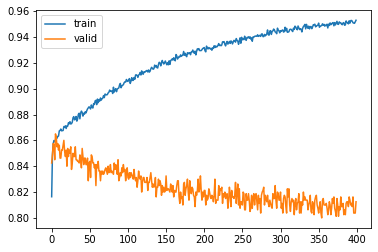

In [19]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)

In [20]:
Precision(thresholds=0.5)
y_pred = model.predict(X_test)

In [21]:
y_pred2 = []
for val in y_pred:
    if val < 0.5:
        y_pred2.append(0)
    else:
        y_pred2.append(1)

In [22]:
metrics.confusion_matrix(y_test, y_pred2)

array([[1444,  120],
       [ 252,  184]])

### I found that if we run the trianing process several times we will have better accurancy of the model, i think the model is learning every time that we run the code